<a href="https://colab.research.google.com/github/yendriferreira/Credit-Card-FraudML/blob/main/PCA_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import os
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

files = os.listdir('/kaggle/input/creditcardfraud')
print("Files in dataset directory:", files)

# Load the CSV into a DataFrame
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

Path to dataset files: /kaggle/input/creditcardfraud
Files in dataset directory: ['creditcard.csv']


 ANÁLISIS PCA ROBUSTO PARA DETECCIÓN DE FRAUDE
 Enfoque: Análisis teórico + evaluación práctica simplificada

 PREPARACIÓN DE DATOS
----------------------------------------
Dataset: (284807, 30)
Fraude: 0.173% | Ratio: 577.9:1
Train: (227845, 30) | Test: (56962, 30)

 ANÁLISIS PCA TEÓRICO
----------------------------------------
Varianza por PC:
  PC1: 6.52%
  PC1-5: 22.33%
  PC1-10: 39.11%
  PC1-15: 55.81%

 CRITERIOS DE SELECCIÓN
----------------------------------------
Criterios de selección:
  80% varianza: 23 componentes (23.3% reducción)
  85% varianza: 24 componentes (20.0% reducción)
  90% varianza: 26 componentes (13.3% reducción)
  95% varianza: 27 componentes (10.0% reducción)
  Kaiser (λ>1): 15 componentes (50.0% reducción)
  Codo: 3 componentes (90.0% reducción)

 CONSENSO: 19 componentes (mediana de criterios)

 GENERANDO VISUALIZACIONES
----------------------------------------


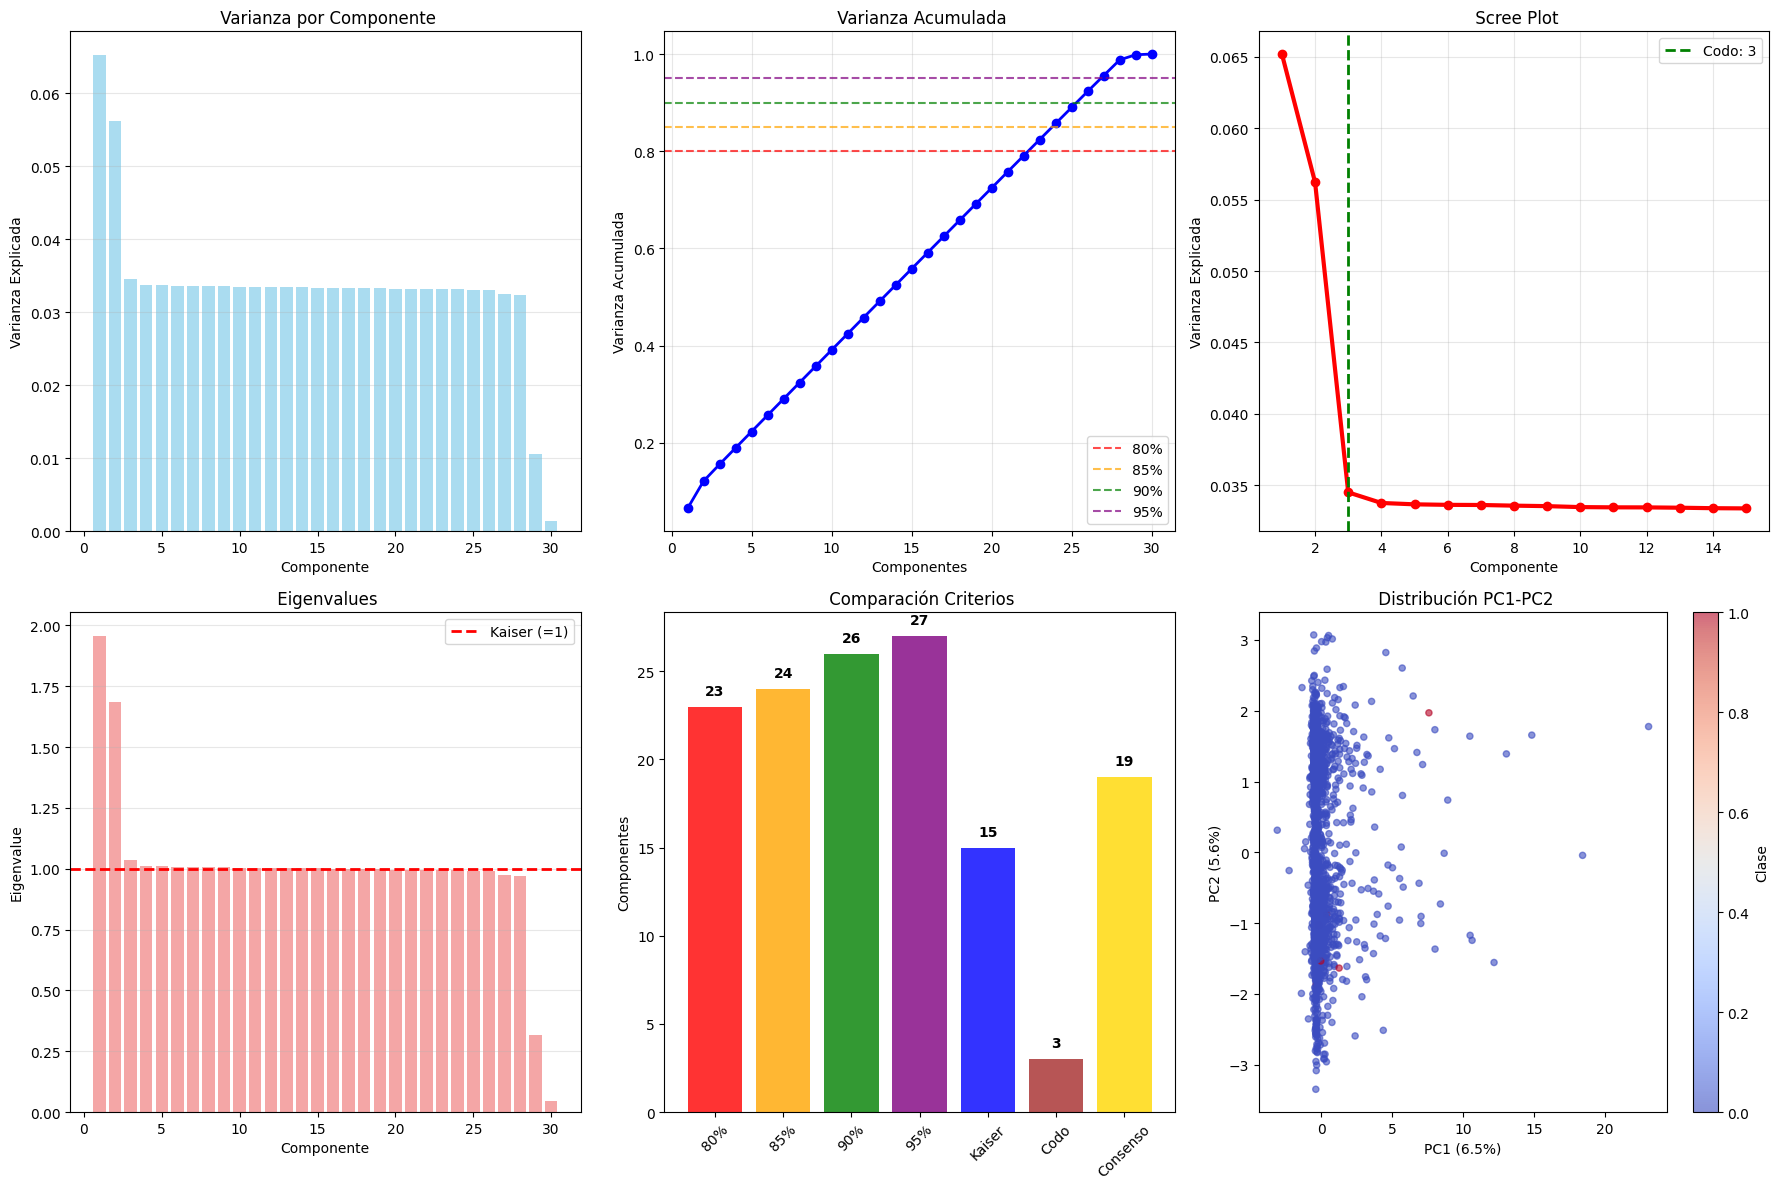


 EVALUACIÓN PRÁCTICA
----------------------------------------
Evaluando configuraciones...
 Original     | 30 comp | RF: 0.8624 | XGB: 0.8652 | Promedio: 0.8638
 Consenso     | 19 comp | RF: 0.8002 | XGB: 0.8044 | Promedio: 0.8023
 Kaiser       | 15 comp | RF: 0.8100 | XGB: 0.7563 | Promedio: 0.7831
 90% Var      | 26 comp | RF: 0.8015 | XGB: 0.8153 | Promedio: 0.8084
 Codo         |  3 comp | RF: 0.1210 | XGB: 0.0697 | Promedio: 0.0954

 ANÁLISIS DE RESULTADOS

 TABLA COMPARATIVA:
--------------------------------------------------------------------------------
Config       Comp Red%  RF_AUPRC XGB_AUPRC Promedio RF_F1 
--------------------------------------------------------------------------------
Original     30   0.0   0.8624   0.8652    0.8638   0.788 
Consenso     19   36.7  0.8002   0.8044    0.8023   0.768 
Kaiser       15   50.0  0.8100   0.7563    0.7831   0.791 
90% Var      26   13.3  0.8015   0.8153    0.8084   0.756 
Codo         3    90.0  0.1210   0.0697    0.0954   0.0

In [2]:

# ANÁLISIS PCA SIMPLIFICADO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import time
import warnings
warnings.filterwarnings('ignore')

print(" ANÁLISIS PCA ROBUSTO PARA DETECCIÓN DE FRAUDE")
print("="*60)
print(" Enfoque: Análisis teórico + evaluación práctica simplificada")


# PREPARACIÓN Y ANÁLISIS TEÓRICO

print(f"\n PREPARACIÓN DE DATOS")
print("-"*40)

X = df.drop('Class', axis=1)
y = df['Class']

print(f"Dataset: {X.shape}")
print(f"Fraude: {y.mean()*100:.3f}% | Ratio: {(y==0).sum()/(y==1).sum():.1f}:1")

# Split y escalado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train_scaled.shape} | Test: {X_test_scaled.shape}")


# PARTE 2: ANÁLISIS PCA COMPLETO

print(f"\n ANÁLISIS PCA TEÓRICO")
print("-"*40)

# PCA completo
pca_full = PCA()
pca_full.fit(X_train_scaled)

explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
eigenvalues = pca_full.explained_variance_

print(f"Varianza por PC:")
print(f"  PC1: {explained_variance_ratio[0]*100:.2f}%")
print(f"  PC1-5: {cumulative_variance[4]*100:.2f}%")
print(f"  PC1-10: {cumulative_variance[9]*100:.2f}%")
print(f"  PC1-15: {cumulative_variance[14]*100:.2f}%")


# CRITERIOS DE SELECCIÓN

print(f"\n CRITERIOS DE SELECCIÓN")
print("-"*40)

# Criterios principales
def find_components_for_variance(cumvar, threshold):
    idx = np.argmax(cumvar >= threshold)
    return idx + 1 if cumvar[idx] >= threshold else len(cumvar)

# Calcular criterios
var_80 = find_components_for_variance(cumulative_variance, 0.80)
var_85 = find_components_for_variance(cumulative_variance, 0.85)
var_90 = find_components_for_variance(cumulative_variance, 0.90)
var_95 = find_components_for_variance(cumulative_variance, 0.95)

kaiser = np.sum(eigenvalues > 1)

# Criterio del codo (simplificado)
def find_elbow_simple(explained_var):
    if len(explained_var) < 3:
        return 3
    diff1 = np.diff(explained_var[:15])
    diff2 = np.diff(diff1)
    elbow = np.argmax(np.abs(diff2)) + 2
    return min(elbow, 15)

elbow = find_elbow_simple(explained_variance_ratio)

print(f"Criterios de selección:")
print(f"  80% varianza: {var_80} componentes ({(1-var_80/30)*100:.1f}% reducción)")
print(f"  85% varianza: {var_85} componentes ({(1-var_85/30)*100:.1f}% reducción)")
print(f"  90% varianza: {var_90} componentes ({(1-var_90/30)*100:.1f}% reducción)")
print(f"  95% varianza: {var_95} componentes ({(1-var_95/30)*100:.1f}% reducción)")
print(f"  Kaiser (λ>1): {kaiser} componentes ({(1-kaiser/30)*100:.1f}% reducción)")
print(f"  Codo: {elbow} componentes ({(1-elbow/30)*100:.1f}% reducción)")

# Consenso
criterios = [var_85, var_90, kaiser, elbow]
consenso = int(np.median(criterios))
print(f"\n CONSENSO: {consenso} componentes (mediana de criterios)")


# VISUALIZACIONES

print(f"\n GENERANDO VISUALIZACIONES")
print("-"*40)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Varianza por componente
axes[0,0].bar(range(1, 31), explained_variance_ratio, alpha=0.7, color='skyblue')
axes[0,0].set_xlabel('Componente')
axes[0,0].set_ylabel('Varianza Explicada')
axes[0,0].set_title(' Varianza por Componente')
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Varianza acumulada
axes[0,1].plot(range(1, 31), cumulative_variance, 'bo-', linewidth=2)
for threshold, color, label in [(0.80, 'red', '80%'), (0.85, 'orange', '85%'),
                               (0.90, 'green', '90%'), (0.95, 'purple', '95%')]:
    axes[0,1].axhline(y=threshold, color=color, linestyle='--', alpha=0.7, label=label)

axes[0,1].set_xlabel('Componentes')
axes[0,1].set_ylabel('Varianza Acumulada')
axes[0,1].set_title(' Varianza Acumulada')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Scree plot
axes[0,2].plot(range(1, 16), explained_variance_ratio[:15], 'ro-', linewidth=3, markersize=6)
axes[0,2].axvline(x=elbow, color='green', linestyle='--', linewidth=2, label=f'Codo: {elbow}')
axes[0,2].set_xlabel('Componente')
axes[0,2].set_ylabel('Varianza Explicada')
axes[0,2].set_title(' Scree Plot')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Eigenvalues
axes[1,0].bar(range(1, 31), eigenvalues, alpha=0.7, color='lightcoral')
axes[1,0].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Kaiser (=1)')
axes[1,0].set_xlabel('Componente')
axes[1,0].set_ylabel('Eigenvalue')
axes[1,0].set_title(' Eigenvalues')
axes[1,0].legend()
axes[1,0].grid(axis='y', alpha=0.3)

# 5. Comparación criterios
criteria_names = ['80%', '85%', '90%', '95%', 'Kaiser', 'Codo', 'Consenso']
criteria_values = [var_80, var_85, var_90, var_95, kaiser, elbow, consenso]

bars = axes[1,1].bar(criteria_names, criteria_values, alpha=0.8,
                    color=['red', 'orange', 'green', 'purple', 'blue', 'brown', 'gold'])
axes[1,1].set_ylabel('Componentes')
axes[1,1].set_title(' Comparación Criterios')
axes[1,1].tick_params(axis='x', rotation=45)

for bar, value in zip(bars, criteria_values):
    axes[1,1].text(bar.get_x() + bar.get_width()/2., value + 0.5,
                  f'{value}', ha='center', va='bottom', fontweight='bold')

# 6. Distribución PC1-PC2
sample_size = min(2000, len(X_train_scaled))
sample_idx = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_sample_pca = pca_full.transform(X_train_scaled[sample_idx])
y_sample = y_train.iloc[sample_idx]

scatter = axes[1,2].scatter(X_sample_pca[:, 0], X_sample_pca[:, 1],
                           c=y_sample, cmap='coolwarm', alpha=0.6, s=20)
axes[1,2].set_xlabel(f'PC1 ({explained_variance_ratio[0]*100:.1f}%)')
axes[1,2].set_ylabel(f'PC2 ({explained_variance_ratio[1]*100:.1f}%)')
axes[1,2].set_title(' Distribución PC1-PC2')
plt.colorbar(scatter, ax=axes[1,2], label='Clase')

plt.tight_layout()
plt.show()


# EVALUACIÓN PRÁCTICA SIMPLIFICADA


print(f"\n EVALUACIÓN PRÁCTICA")
print("-"*40)

# Configuraciones a evaluar
configs_to_test = [
    ("Original", 30),
    ("Consenso", consenso),
    ("Kaiser", kaiser),
    ("90% Var", var_90),
    ("Codo", elbow)
]

# Modelos
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=20, min_samples_split=2,
    class_weight='balanced', random_state=42, n_jobs=-1
)

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_model = xgb.XGBClassifier(
    n_estimators=100, max_depth=6, learning_rate=0.1,
    scale_pos_weight=scale_pos_weight, eval_metric='logloss',
    random_state=42, n_jobs=-1
)

# Función de evaluación simple
def evaluar_config(nombre, n_comp, X_train_sc, X_test_sc):
    resultados = {"config": nombre, "n_comp": n_comp}

    try:
        # Preparar datos
        if n_comp == 30:  # Original
            X_tr, X_te = X_train_sc, X_test_sc
        else:  # PCA
            pca = PCA(n_components=n_comp, random_state=42)
            X_tr = pca.fit_transform(X_train_sc)
            X_te = pca.transform(X_test_sc)
            resultados["var_preservada"] = pca.explained_variance_ratio_.sum()

        resultados["reduccion"] = (1 - n_comp/30) * 100

        # SMOTE
        smote = SMOTE(random_state=42, k_neighbors=3)
        X_tr_bal, y_tr_bal = smote.fit_resample(X_tr, y_train)

        # Random Forest
        start_time = time.time()
        rf_model.fit(X_tr_bal, y_tr_bal)
        y_pred_rf = rf_model.predict(X_te)
        y_proba_rf = rf_model.predict_proba(X_te)[:, 1]
        rf_time = time.time() - start_time

        resultados["rf_auprc"] = average_precision_score(y_test, y_proba_rf)
        resultados["rf_f1"] = f1_score(y_test, y_pred_rf)
        resultados["rf_tiempo"] = rf_time

        # XGBoost (sin SMOTE, usa scale_pos_weight)
        start_time = time.time()
        xgb_model.fit(X_tr, y_train)
        y_pred_xgb = xgb_model.predict(X_te)
        y_proba_xgb = xgb_model.predict_proba(X_te)[:, 1]
        xgb_time = time.time() - start_time

        resultados["xgb_auprc"] = average_precision_score(y_test, y_proba_xgb)
        resultados["xgb_f1"] = f1_score(y_test, y_pred_xgb)
        resultados["xgb_tiempo"] = xgb_time

        # Promedio
        resultados["auprc_promedio"] = (resultados["rf_auprc"] + resultados["xgb_auprc"]) / 2
        resultados["exito"] = True

        print(f" {nombre:<12} | {n_comp:2d} comp | "
              f"RF: {resultados['rf_auprc']:.4f} | XGB: {resultados['xgb_auprc']:.4f} | "
              f"Promedio: {resultados['auprc_promedio']:.4f}")

    except Exception as e:
        print(f" {nombre:<12} | Error: {str(e)[:30]}...")
        resultados.update({
            "rf_auprc": 0, "rf_f1": 0, "rf_tiempo": 0,
            "xgb_auprc": 0, "xgb_f1": 0, "xgb_tiempo": 0,
            "auprc_promedio": 0, "exito": False, "reduccion": (1 - n_comp/30) * 100
        })

    return resultados

# Evaluar todas las configuraciones
print(f"Evaluando configuraciones...")
resultados_evaluacion = []

for nombre, n_comp in configs_to_test:
    resultado = evaluar_config(nombre, n_comp, X_train_scaled, X_test_scaled)
    resultados_evaluacion.append(resultado)


# PARTE 6: ANÁLISIS DE RESULTADOS

print(f"\n ANÁLISIS DE RESULTADOS")
print("="*60)

# Filtrar resultados exitosos
resultados_exitosos = [r for r in resultados_evaluacion if r["exito"]]

if resultados_exitosos:
    # Tabla comparativa
    print(f"\n TABLA COMPARATIVA:")
    print("-" * 80)
    print(f"{'Config':<12} {'Comp':<4} {'Red%':<5} {'RF_AUPRC':<8} {'XGB_AUPRC':<9} {'Promedio':<8} {'RF_F1':<6}")
    print("-" * 80)

    for r in resultados_exitosos:
        print(f"{r['config']:<12} {r['n_comp']:<4} {r['reduccion']:<5.1f} "
              f"{r['rf_auprc']:<8.4f} {r['xgb_auprc']:<9.4f} {r['auprc_promedio']:<8.4f} {r['rf_f1']:<6.3f}")

    # Encontrar mejor configuración
    mejor = max(resultados_exitosos, key=lambda x: x["auprc_promedio"])
    original = next(r for r in resultados_exitosos if r["config"] == "Original")

    # Calcular cambios vs original
    cambio_auprc = ((mejor["auprc_promedio"] - original["auprc_promedio"]) / original["auprc_promedio"]) * 100

    print(f"\n MEJOR CONFIGURACIÓN:")
    print(f"   {mejor['config']}: {mejor['n_comp']} componentes")
    print(f"   AUPRC promedio: {mejor['auprc_promedio']:.4f}")
    print(f"   Reducción: {mejor['reduccion']:.1f}%")
    if "var_preservada" in mejor:
        print(f"   Varianza preservada: {mejor['var_preservada']*100:.1f}%")
    print(f"   Cambio vs Original: {cambio_auprc:+.2f}%")

    # Recomendación final
    print(f"\n RECOMENDACIÓN FINAL:")
    print("-" * 30)

    if cambio_auprc >= -2:
        recomendacion = " USAR PCA"
        razon = f"Excelente trade-off: {mejor['reduccion']:.1f}% reducción con mínima pérdida"
    elif cambio_auprc >= -5:
        recomendacion = " CONSIDERAR PCA"
        razon = f"Trade-off aceptable según restricciones computacionales"
    else:
        recomendacion = " MANTENER ORIGINAL"
        razon = f"Pérdida de rendimiento significativa ({cambio_auprc:.1f}%)"

    print(f"{recomendacion}")
    print(f"Razón: {razon}")

    print(f"\n IMPLEMENTACIÓN:")
    if "USAR" in recomendacion or "CONSIDERAR" in recomendacion:
        print(f"```python")
        print(f"# Usar {mejor['config']} con {mejor['n_comp']} componentes")
        print(f"pca = PCA(n_components={mejor['n_comp']}, random_state=42)")
        print(f"X_train_pca = pca.fit_transform(X_train_scaled)")
        print(f"X_test_pca = pca.transform(X_test_scaled)")
        print(f"# Reducción: {mejor['reduccion']:.1f}%")
        print(f"# AUPRC esperado: {mejor['auprc_promedio']:.4f}")
        print(f"```")
    else:
        print(f"Mantener las 30 características originales")
        print(f"AUPRC con características completas: {original['auprc_promedio']:.4f}")

else:
    print(f" No se pudieron evaluar las configuraciones")
    print(f" Recomendación teórica: {consenso} componentes")
    print(f"   Basado en consenso entre criterios matemáticos")
    print(f"   Reducción estimada: {(1-consenso/30)*100:.1f}%")

print(f"\n ANÁLISIS COMPLETADO!")
print(f" Evaluación robusta de PCA para detección de fraude")
print(f" Recomendación basada en criterios teóricos y evaluación práctica")